### Stanford 40

In [7]:
from collections import Counter
from sklearn.model_selection import train_test_split

keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse", 
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]
with open('ImageSplits/train.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    train_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]

with open('ImageSplits/test.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    test_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]

# Combine the splits and split for keeping more images in the training set than the test set.
all_files = train_files + test_files
all_labels = train_labels + test_labels
train_files, test_files = train_test_split(all_files, test_size=0.1, random_state=0, stratify=all_labels)
train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]
print(f'Train files ({len(train_files)}):\n\t{train_files}')
print(f'Train labels ({len(train_labels)}):\n\t{train_labels}\n'\
      f'Train Distribution:{list(Counter(sorted(train_labels)).items())}\n')
print(f'Test files ({len(test_files)}):\n\t{test_files}')
print(f'Test labels ({len(test_labels)}):\n\t{test_labels}\n'\
      f'Test Distribution:{list(Counter(sorted(test_labels)).items())}\n')
action_categories = sorted(list(set(train_labels)))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')

Train files (2733):
	['drinking_203.jpg', 'smoking_048.jpg', 'running_099.jpg', 'jumping_186.jpg', 'smoking_205.jpg', 'riding_a_bike_090.jpg', 'climbing_184.jpg', 'throwing_frisby_078.jpg', 'applauding_185.jpg', 'throwing_frisby_131.jpg', 'running_241.jpg', 'riding_a_horse_229.jpg', 'throwing_frisby_009.jpg', 'climbing_126.jpg', 'waving_hands_188.jpg', 'shooting_an_arrow_062.jpg', 'riding_a_horse_191.jpg', 'applauding_087.jpg', 'applauding_074.jpg', 'riding_a_bike_181.jpg', 'running_091.jpg', 'riding_a_bike_188.jpg', 'riding_a_bike_027.jpg', 'throwing_frisby_035.jpg', 'climbing_022.jpg', 'applauding_095.jpg', 'waving_hands_024.jpg', 'running_225.jpg', 'climbing_224.jpg', 'riding_a_bike_108.jpg', 'running_050.jpg', 'jumping_089.jpg', 'pouring_liquid_089.jpg', 'climbing_087.jpg', 'applauding_143.jpg', 'jumping_069.jpg', 'waving_hands_039.jpg', 'smoking_019.jpg', 'drinking_030.jpg', 'running_189.jpg', 'climbing_159.jpg', 'climbing_221.jpg', 'drinking_162.jpg', 'drinking_210.jpg', 'riding_

<h5>Create a validation set by sampling 10% of the training data with stratification</h5>

In [14]:
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.1, random_state=0, stratify=train_labels)

<h5>Stanford 40 – Frames custom CNN training and evaluation pipeline</h5>

Epoch [1/10], Train Loss: 3.0393, Train Acc: 0.0976, Val Loss: 2.4058, Val Acc: 0.0976
Epoch [2/10], Train Loss: 2.3352, Train Acc: 0.1916, Val Loss: 2.2469, Val Acc: 0.2520
Epoch [3/10], Train Loss: 1.9147, Train Acc: 0.3615, Val Loss: 2.2035, Val Acc: 0.2642
Epoch [4/10], Train Loss: 1.1712, Train Acc: 0.6353, Val Loss: 2.3677, Val Acc: 0.2520
Epoch [5/10], Train Loss: 0.3723, Train Acc: 0.9051, Val Loss: 2.8069, Val Acc: 0.2439
Epoch [6/10], Train Loss: 0.0642, Train Acc: 0.9932, Val Loss: 3.4272, Val Acc: 0.2886
Epoch [7/10], Train Loss: 0.0096, Train Acc: 0.9995, Val Loss: 3.2843, Val Acc: 0.3049
Epoch [8/10], Train Loss: 0.0031, Train Acc: 1.0000, Val Loss: 3.4403, Val Acc: 0.2846
Epoch [9/10], Train Loss: 0.0018, Train Acc: 1.0000, Val Loss: 3.5411, Val Acc: 0.2927
Epoch [10/10], Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 3.6191, Val Acc: 0.2886
Test Accuracy: 0.3289


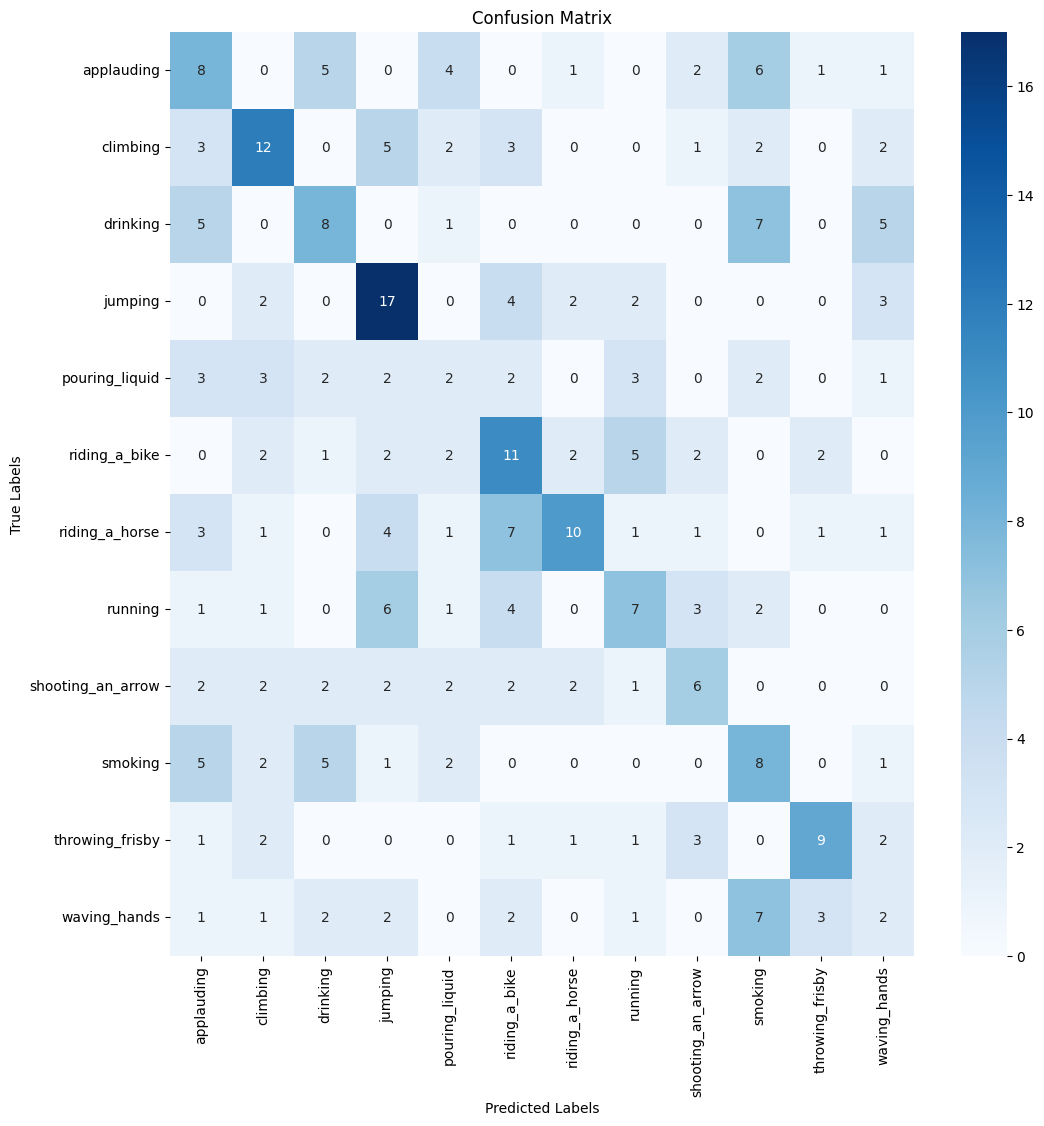

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Define the path to the 'JPEGImages' folder
jpeg_folder = 'JPEGImages'

# Define the data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a dictionary to map action categories to integer labels
action_to_idx = {action: idx for idx, action in enumerate(action_categories)}
# Create custom dataset
class Stanford40Dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, labels, jpeg_folder, transform=None):
        self.file_list = file_list
        self.labels = [action_to_idx[label] for label in labels]  # Convert labels to integers
        self.jpeg_folder = jpeg_folder
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_name = self.file_list[index]
        img_path = os.path.join(self.jpeg_folder, img_name)
        img = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            img = self.transform(img)

        return img, label

# Create data loaders
train_dataset = Stanford40Dataset(train_files, train_labels, jpeg_folder, transform=data_transforms)
val_dataset = Stanford40Dataset(val_files, val_labels, jpeg_folder, transform=data_transforms)
test_dataset = Stanford40Dataset(test_files, test_labels, jpeg_folder, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the custom CNN architecture
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = CustomCNN(num_classes=len(action_categories)).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_dataset)
    train_acc = train_acc.double() / len(train_dataset)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_dataset)
    val_acc = val_acc.double() / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

# Evaluate the model on the test set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_acc = 0.0
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_acc += torch.sum(preds == labels.data)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = test_acc.double() / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=action_categories, yticklabels=action_categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()